# **Welcome to the Spotify Project**!

After reading the Gnod Project Introduction, you are now ready to develop the product that Jane, the CTO of Gnod, asked you to create. You will present it on Friday, where it will be live-tested to assess how good your song recommendations are! 


- [**Spotify API Documentation**](https://spotipy.readthedocs.io/en/2.24.0/#api-reference)

- [**Streamlit**](https://spotify-songs-recommendation.streamlit.app/)

---

## Instructions

### DAY 1:
**Objective:**
- Install necessary libraries and create a Spotify developer account (if not done).
- Create a DataFrame with the top 100 songs and respective artists by scraping the website [Billboard Hot 100](https://www.billboard.com/charts/hot-100/).
  - The DataFrame should have 2 columns: `song_title`, `artist`.

- Create a Python program that takes a user input, checks if it is present in your scraped DataFrame.
  - If it is, it recommends a random song from the DataFrame.
  - If it’s not, it prints: `Sorry, your song is not popular`.
  - *Important note*: For now, you will not use the DataFrame of audio features you created yesterday.


### DAY 2:
**Objective:**
  - Using the `Spotipy` library, create a DataFrame storing the `audio_features` of at least 1000 songs.
  - [**Audio features explanation**](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)
  - The more diverse your playlist, the better the end result will be!

### DAY 3:
**Objective:**
- Using one of the Unsupervised Learning Algorithms that we have covered, create a model using the audio features DataFrame you created on Tuesday.

### DAY 4:
**Objective:**
- Finalize the project: Your final program should check if a song is present in your scraped `billboard_hot100` DataFrame.
  - If it is, it should recommend a random song from that DataFrame.
  - If not, it should recommend a song based on musical similarity.

---

## **Libraries Import & Settings**

In [3]:
# Standard library imports
import time
import random

# Third-party library imports
import requests
from requests.exceptions import RequestException
from bs4 import BeautifulSoup
import pandas as pd
from fuzzywuzzy import process
from textblob import TextBlob
from IPython.display import IFrame

# Spotipy library imports
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
from spotipy.exceptions import SpotifyException


import pickle
from sklearn import datasets 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN


In [4]:
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_rows')

## **Billboard Hot 100 hits**

In [6]:
#url = "https://www.billboard.com/charts/hot-100/"
#response = requests.get(url)

#if response.status_code == 200:
#    print("Page fetched successfully!")
#    html_content = response.content
#else:
#    print("Failed to retrieve the page!")

#soup = BeautifulSoup(html_content, "html.parser")

# Scrape song titles
#songs = [song.get_text(strip=True) for song in soup.select("li.o-chart-results-list__item h3")]

# Scrape artist names
#artists = [artist.get_text(strip=True) for artist in soup.select("li.o-chart-results-list__item h3 + span")]

# Scrape ranks
#ranks = range(1, len(songs) + 1)

# Combine data into a DataFrame
#billboard_hot_100 = pd.DataFrame({
#    "song_title": songs,
#    "artist": artists
#})

#billboard_hot_100

In [7]:
# Save to a subfolder in the current directory
#file_path = '/Users/mbouch17/Desktop/IronHack/Labs &  Project/spotify-song-recommendation/csv_files/billboard_hot_100.csv'

# Save to CSV
#billboard_hot_100.to_csv(file_path, index=False)

##  **iTunes DE Top 100 songs**

In [9]:
# URL of the PopVortex Germany Top Songs page
#url2 = "https://www.popvortex.com/music/germany/top-songs.php"

# Fetch the page content
#response = requests.get(url2)
#response.raise_for_status()  # Ensure the request was successful

# Parse the HTML content using BeautifulSoup
#soup2 = BeautifulSoup(response.text, "html.parser")

# Locate song titles and artists based on the updated structure
#titles = [title.text.strip() for title in soup2.select("cite.title")]
#artists = [artist.text.strip() for artist in soup2.select("em.artist")]

# Create a DataFrame
#itunes_de_100 = pd.DataFrame({
#    "song_title": titles,
#    "artist": artists
#})

# Save to CSV
#itunes_de_100.to_csv("/Users/mbouch17/Desktop/IronHack/Labs &  Project/spotify-song-recommendation/csv_files/iTunes_DE_100.csv", index=False)
#itunes_de_100

## **Merge WW & DE dataframe | 'ww_de'**

In [11]:
# Add origin columns to each DataFrame
#billboard_hot_100["origin"] = "WW"
#itunes_de_100["origin"] = "DE"

# Normalize song titles for case-insensitive matching
#billboard_hot_100["song_title_normalized"] = billboard_hot_100["song_title"].str.lower()
#itunes_de_100["song_title_normalized"] = itunes_de_100["song_title"].str.lower()

# Merge the two DataFrames on normalized song titles
#merged_df = pd.merge(
#    billboard_hot_100,
#    itunes_de_100,
#    on="song_title_normalized",
 #   suffixes=('_billboard', '_itunes'),
 #   how="outer"
#)

# Determine the origin column
#def determine_origin(row):
#    if pd.notnull(row["origin_billboard"]) and pd.notnull(row["origin_itunes"]):
#        return "WW_DE"
#    elif pd.notnull(row["origin_billboard"]):
#        return "WW"
#    elif pd.notnull(row["origin_itunes"]):
#        return "DE"
#    return None

#merged_df["origin"] = merged_df.apply(determine_origin, axis=1)

# Create the final DataFrame with only the required columns
#ww_de = pd.DataFrame({
#    "song_title": merged_df["song_title_normalized"].str.title(),
#    "artist": merged_df["artist_billboard"].combine_first(merged_df["artist_itunes"]),
#    "origin": merged_df["origin"]
#})

#ww_de

In [12]:
# Save to a subfolder in the current directory
#file_path = '/Users/mbouch17/Desktop/IronHack/Labs &  Project/spotify-song-recommendation/csv_files/ww_de.csv'

# Save to CSV
#ww_de.to_csv(file_path, index=False)
#ww_de.head(60)

# URL of the CSV file
url = 'https://raw.githubusercontent.com/Marc-Bouche/spotify-song-recommendation/refs/heads/main/csv_files/ww_de.csv'

# Importing the CSV into a DataFrame
ww_de = pd.read_csv(url)

## **User Input**

In [33]:
## Function to recommend song
def recommend_song(user_input):
    # Normalize input to lowercase and remove extra spaces
    user_input = user_input.strip().lower()

    # Use spelling correction to handle minor typos
    user_input = str(TextBlob(user_input).correct())

    # Use fuzzywuzzy to match the input with song_title or artist
    titles = ww_de['song_title'].tolist()
    artists = ww_de['artist'].tolist()

    # Try to match the input with song titles and artists
    matched_title, score_title = process.extractOne(user_input, titles)
    matched_artist, score_artist = process.extractOne(user_input, artists)

    # Set a threshold for acceptable match scores (e.g., 80%)
    if score_title >= 80 or score_artist >= 80:
        # Show matched song and artist
        matched_song_info = ww_de[(ww_de['song_title'] == matched_title) | (ww_de['artist'] == matched_artist)]
        
        print(f"\nFound a match: {matched_song_info.iloc[0]['song_title']} by {matched_song_info.iloc[0]['artist']}")
        
        # Ask for confirmation before recommending a random song
        while True:
            confirm = input("Would you like a random song recommendation from the list? (yes/no): ").strip().lower()

            if confirm == 'yes':
                # Recommend a random song
                random_song = ww_de.sample(n=1).iloc[0]
                print(f"How about this one: {random_song['song_title']} by {random_song['artist']}")
                return True  # Continue to menu
            elif confirm == 'no':
                print("Okay, no recommendations at the moment.")
                return False  # Indicate to stop
            else:
                print("Invalid input. Please enter 'yes' or 'no'.")
    else:
        print("Sorry, no popular match found for your song or artist.")
    return True  # Continue processing

# Main program
def main():
    while True:
        user_input = input("Enter a song title or artist: ").strip()
        
        if user_input:
            continue_recommendation = recommend_song(user_input)
            if not continue_recommendation:
                break  # Exit the main loop if user says 'no'

            while True:
                # Ask user for the next action
                choice = input("\nWould you like to:\n(1) Get another recommendation based on the same artist/song\n(2) Type a new artist/song\n(3) Exit\nEnter 1, 2, or 3: ").strip()

                if choice == '1':
                    # Get another recommendation and return to this menu
                    continue_recommendation = recommend_song(user_input)
                    if not continue_recommendation:
                        return  # Exit the entire program
                elif choice == '2':
                    # Ask for a new artist/song
                    break
                elif choice == '3':
                    print("Thank you for using the song recommendation system!")
                    return  # Exit the entire program
                else:
                    print("Invalid input. Please enter 1, 2, or 3.")
        else:
            print("Please enter a valid song title or artist.")

# Start the program
if __name__ == "__main__":
    main()


Enter a song title or artist:  coldplay



Found a match: Feelslikeimfallinginlove by Coldplay


Would you like a random song recommendation from the list? (yes/no):  yes


How about this one: It'S Beginning To Look A Lot Like Christmas by Michael Bublé



Would you like to:
(1) Get another recommendation based on the same artist/song
(2) Type a new artist/song
(3) Exit
Enter 1, 2, or 3:  2
Enter a song title or artist:  charlie winston


Sorry, no popular match found for your song or artist.



Would you like to:
(1) Get another recommendation based on the same artist/song
(2) Type a new artist/song
(3) Exit
Enter 1, 2, or 3:  3


Thank you for using the song recommendation system!


## **Spotify**

### Connect API

In [127]:
from spotify_config import client_id, client_secret

In [129]:
# Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,client_secret=client_secret))

### Fetch [**audio features**](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) of 1000+ songs

####  LIST OF GENRE 1 : ['love', 'dance', 'happy', 'rock', 'pop', 'jazz', 'indie', 'classical', 'hip hop', 'chill', 'blues', 'reggae', 'party', 'electronic', 'latin']

In [61]:
# Function to fetch track IDs based on search queries
#def get_track_ids(query, limit=50, offset=0):
#    results = sp.search(q=query, type='track', limit=limit, offset=offset)
#    return [track['id'] for track in results['tracks']['items']]

# Function to fetch audio features for a list of track IDs
def get_audio_features(track_ids):
    features = sp.audio_features(track_ids)
    return [f for f in features if f]  # Filter out None results

# Generate a diverse list of queries
#queries = ['love', 'dance', 'happy', 'rock', 'pop', 'jazz', 'indie', 'classical', 
#           'hip hop', 'chill', 'blues', 'reggae', 'party', 'electronic', 'latin']

# Fetch and process data
#all_features = []
#seen_track_ids = set()  # To ensure unique tracks

# Outer loop to iterate over queries
#for query in queries:
#    for offset in range(0, 1000, 50):  # Iterate with offsets to get more tracks
#        track_ids = get_track_ids(query, limit=50, offset=offset)
#        unique_track_ids = [t for t in track_ids if t not in seen_track_ids]  # Filter unique IDs
#        seen_track_ids.update(unique_track_ids)

#        features = get_audio_features(unique_track_ids)  # Fetch audio features
#        all_features.extend(features)  # Append to the master list

#        if len(all_features) >= 1000:  # Stop once we have 1000+ songs
#            break

#    if len(all_features) >= 1000:  # Stop outer loop if we hit the target
#        break

# Create a DataFrame from the features
#df_audio_features = pd.DataFrame(all_features)

# Fetch track details in bulk
#tracks = sp.tracks([track['id'] for track in all_features])  # Fetch track details in bulk

# Map artist and song names to the corresponding track IDs
#df_audio_features['artist'] = df_audio_features['id'].map(lambda track_id: next((track['artists'][0]['name'] for track in tracks['tracks'] if track['id'] == track_id), 'Unknown'))
#df_audio_features['song'] = df_audio_features['id'].map(lambda track_id: next((track['name'] for track in tracks['tracks'] if track['id'] == track_id), 'Unknown'))

# Reorder the columns to place 'id', 'artist', and 'song' at the start
#df_audio_features = df_audio_features[['id', 'artist', 'song'] + [col for col in df_audio_features.columns if col not in ['id', 'artist', 'song']]]

# Save to CSV
#df_audio_features.to_csv("/Users/mbouch17/Desktop/IronHack/Labs &  Project/spotify-song-recommendation/csv_files/df_audio_features.csv", index=False)

# Display the first few rows
#df_audio_features.head()


In [63]:
# df_audio_features.shape

In [65]:
# Play the song using the song id in track_id!

track_id = '7aQjPecQdIuNd1sz3KCDhD'
#track_id= 'spotify:track:3hgl7EQwTutSm6PESsB7gZ'
IFrame(src="https://open.spotify.com/embed/track/"+track_id,
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [67]:
# df_audio_features.head(20)

In [69]:
# df_audio_features.shape

In [71]:
# Save the updated DataFrame to CSV
# df_audio_features.to_csv("/Users/mbouch17/Desktop/IronHack/Labs &  Project/spotify-song-recommendation/csv_files/df_audio_features_with_artist_song.csv", index=False)
# df_audio_features

####  LIST OF GENRE 2: ['country', 'metal', 'alternative', 'folk', 'punk', 'r&b', 'soul', 'techno', 'house', 'disco', 'ambient', 'industrial']

In [74]:
# def fetch_track_metadata_with_backoff(track_ids, retries=5):
#    """
#    Fetch artist and song metadata for a list of track IDs with retry logic.
#    """
#    track_metadata = []
#    for i in range(retries):
#        try:
#            for track_id in track_ids:
#                track = sp.track(track_id)  # Fetch track details
#                track_metadata.append({
#                    'id': track_id,
#                    'artist': ', '.join([artist['name'] for artist in track['artists']]),  # Handles multiple artists
#                    'song': track['name']
#                })
#            return track_metadata
#        except Exception as e:
#            if i < retries - 1:
#                time.sleep(2 ** i)  # Exponential backoff
#            else:
#                raise e

# Assuming `df_audio_features2` is created in your original code
# Extract unique track IDs from the DataFrame
#unique_track_ids = df_audio_features2['id'].unique()

# Fetch metadata for the unique track IDs
#metadata = fetch_track_metadata_with_backoff(unique_track_ids)

# Convert metadata to a DataFrame
#df_metadata = pd.DataFrame(metadata)

# Merge metadata with the original audio features DataFrame
#df_audio_features2 = df_metadata.merge(df_audio_features2, on='id')

# Reorder columns to place artist, song, and id at the beginning
#columns_order = ['artist', 'song', 'id'] + [col for col in df_audio_features2.columns if col not in ['artist', 'song', 'id']]
#df_audio_features2 = df_audio_features2[columns_order]

In [76]:
# def get_track_ids_with_retry(query, limit=50, offset=0, retries=5):
#    for i in range(retries):
#        try:
#            return sp.search(q=query, type='track', limit=limit, offset=offset)['tracks']['items']
#        except Exception as e:
#            if i < retries - 1:
#                time.sleep(2 ** i)  # Exponential backoff
#            else:
#                raise e

#def fetch_audio_features_with_backoff(track_ids, retries=5):
#    for i in range(retries):
#        try:
#            return sp.audio_features(track_ids)
#        except Exception as e:
#            if i < retries - 1:
#                time.sleep(2 ** i)  # Exponential backoff
#            else:
#                raise e

# Main processing loop
#all_features = []
#seen_track_ids = set()

#queries = ['country', 'metal', 'alternative', 'folk', 'punk', 'r&b', 'soul', 'techno', 'house', 'disco', 'ambient', 'industrial']

#for query in queries:
#    for offset in range(0, 1000, 50):
#        tracks = get_track_ids_with_retry(query=query, limit=50, offset=offset)
#        track_ids = [t['id'] for t in tracks if t['id'] not in seen_track_ids]
#        seen_track_ids.update(track_ids)

#        features = fetch_audio_features_with_backoff(track_ids)
#        all_features.extend(f for f in features if f)  # Filter None results

#        if len(all_features) >= 1000:
#            break
#    if len(all_features) >= 1000:
#        break

# Convert to DataFrame and save
# df_audio_features2 = pd.DataFrame(all_features)


#### Fetching Popular playlists


In [79]:
# Function to fetch audio features of songs in chunks of 100
#def fetch_audio_features(song_ids):
#    audio_features = []
    
    # Split the list of song IDs into chunks of 100
#    for i in range(0, len(song_ids), 100):
#        chunk = song_ids[i:i + 100]
#        try:
#            # Fetch audio features for the current chunk
#            features = sp.audio_features(chunk)
#            audio_features.extend(features)
#        except Exception as e:
#            print(f"Error fetching audio features for chunk: {chunk}\n{e}")
    
#    return audio_features

# Assuming you want at least 2000 songs
# Fetch more songs if needed (example shown for adding more songs if your data source allows it)
#song_ids = playlist_songs_df['track_id'].tolist()  # Extract track IDs

# If there are fewer than 2000 songs, extend the list (Example for adding more, adapt to your data source)
#num_songs = len(song_ids)
#if num_songs < 2000:
#    print(f"Warning: Only {num_songs} songs are available. Adding more songs to meet the minimum requirement.")
    # You can append more song IDs here from another source or playlist
    # Example: song_ids.extend(extra_song_ids)  # extra_song_ids needs to be defined elsewhere
    
# Fetch the audio features for the songs
#audio_features = fetch_audio_features(song_ids)

# Convert the audio features into a DataFrame
#audio_features_df = pd.DataFrame(audio_features)

# Merge audio features with the playlist songs DataFrame
#df_playlist = pd.concat([playlist_songs_df, audio_features_df], axis=1)

# Assuming df_combined contains your existing songs dataset, merge the new songs
#df_combined = pd.concat([df_combined, df_playlist], ignore_index=True)

# Display the updated DataFrame with audio features
#df_combined.head()


In [81]:
df_combined.shape

(2367, 21)

In [83]:
df_combined.isnull().sum()

id                  0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
artist              0
song_title          0
cluster             0
dtype: int64

### Merge & Clean Audio features dataframes


In [86]:
# URL of the CSV file
url = 'https://raw.githubusercontent.com/Marc-Bouche/spotify-song-recommendation/refs/heads/main/csv_files/df_audio_features_with_artist_song.csv'

# Importing the CSV into a DataFrame
df_audio_features = pd.read_csv(url)

# Display the first few rows to check the data
df_audio_features.head()


,id,song,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,7hR22TOX3RorxJPcsz5Wbo,Love Somebody,Morgan Wallen,0.619,0.843,5,-5.348,0,0.0284,0.009480,0.000118,0.1640,0.746,122.064,audio_features,spotify:track:7hR22TOX3RorxJPcsz5Wbo,https://api.spotify.com/v1/tracks/7hR22TOX3Ror...,https://api.spotify.com/v1/audio-analysis/7hR2...,204829,4
1,0W4NhJhcqKCqEP2GIpDCDq,Love,Keyshia Cole,0.688,0.518,5,-4.285,1,0.0283,0.064200,0.000000,0.1000,0.314,116.714,audio_features,spotify:track:0W4NhJhcqKCqEP2GIpDCDq,https://api.spotify.com/v1/tracks/0W4NhJhcqKCq...,https://api.spotify.com/v1/audio-analysis/0W4N...,255333,4
2,6dBUzqjtbnIa1TwYbyw5CM,Lovers Rock,TV Girl,0.559,0.871,5,-5.338,0,0.0397,0.000008,0.005450,0.0960,0.572,104.970,audio_features,spotify:track:6dBUzqjtbnIa1TwYbyw5CM,https://api.spotify.com/v1/tracks/6dBUzqjtbnIa...,https://api.spotify.com/v1/audio-analysis/6dBU...,213920,4
3,2XHzzp1j4IfTNp1FTn7YFg,Love Me,"Lil Wayne, Drake, Future",0.670,0.634,11,-6.471,1,0.0326,0.012400,0.000000,0.0946,0.497,124.926,audio_features,spotify:track:2XHzzp1j4IfTNp1FTn7YFg,https://api.spotify.com/v1/tracks/2XHzzp1j4IfT...,https://api.spotify.com/v1/audio-analysis/2XHz...,255053,4
4,0u2P5u6lvoDfwTYjAADbn4,lovely (with Khalid),"Billie Eilish, Khalid",0.351,0.296,4,-10.109,0,0.0333,0.934000,0.000000,0.0950,0.120,115.284,audio_features,spotify:track:0u2P5u6lvoDfwTYjAADbn4,https://api.spotify.com/v1/tracks/0u2P5u6lvoDf...,https://api.spotify.com/v1/audio-analysis/0u2P...,200186,4


In [87]:
# URL of the CSV file
url2 = 'https://raw.githubusercontent.com/Marc-Bouche/spotify-song-recommendation/refs/heads/main/csv_files/df_audio_features2.csv'

# Importing the CSV into a DataFrame
df_audio_features2 = pd.read_csv(url2)

# Display the first few rows to check the data
df_audio_features2.head()


,artist,song,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,John Denver,"Take Me Home, Country Roads - Original Version",1YYhDizHx7PnDhAhko6cDS,0.462,0.395,9,-9.376,1,0.0264,0.75800,0.000000,0.1210,0.625,82.259,audio_features,spotify:track:1YYhDizHx7PnDhAhko6cDS,https://api.spotify.com/v1/tracks/1YYhDizHx7Pn...,https://api.spotify.com/v1/audio-analysis/1YYh...,190160,4
1,Luke Bryan,Country Girl (Shake It For Me),0JbSghVDghtFEurrSO8JrC,0.644,0.904,2,-4.532,1,0.0464,0.02950,0.000000,0.0834,0.672,105.969,audio_features,spotify:track:0JbSghVDghtFEurrSO8JrC,https://api.spotify.com/v1/tracks/0JbSghVDghtF...,https://api.spotify.com/v1/audio-analysis/0JbS...,225560,4
2,Luke Combs,When It Rains It Pours,1mMLMZYXkMueg65jRRWG1l,0.551,0.801,6,-5.069,1,0.0303,0.01300,0.000006,0.2650,0.625,128.027,audio_features,spotify:track:1mMLMZYXkMueg65jRRWG1l,https://api.spotify.com/v1/tracks/1mMLMZYXkMue...,https://api.spotify.com/v1/audio-analysis/1mML...,240760,4
3,Nelly,Country Grammar (Hot Shit),3wMUvT6eIw2L5cZFG1yH9j,0.881,0.663,2,-6.822,1,0.0827,0.00683,0.000000,0.1420,0.586,81.374,audio_features,spotify:track:3wMUvT6eIw2L5cZFG1yH9j,https://api.spotify.com/v1/tracks/3wMUvT6eIw2L...,https://api.spotify.com/v1/audio-analysis/3wMU...,287000,4
4,Morgan Wallen,You Proof,5W4kiM2cUYBJXKRudNyxjW,0.728,0.818,9,-5.068,1,0.0329,0.32300,0.000000,0.5820,0.681,119.706,audio_features,spotify:track:5W4kiM2cUYBJXKRudNyxjW,https://api.spotify.com/v1/tracks/5W4kiM2cUYBJ...,https://api.spotify.com/v1/audio-analysis/5W4k...,157478,4


In [88]:
# Merge the dataframes on 'id' with an outer join to keep all data
#df_combined = df_audio_features.merge(df_audio_features2, on='id', how='outer')

# Combine the columns (e.g., 'danceability', 'energy', etc.) using combine_first
#columns_to_combine = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
#                      'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
#                      'type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature']

#for col in columns_to_combine:
    # Combine the '_x' and '_y' columns
#    df_combined[col] = df_combined[f'{col}_x'].combine_first(df_combined[f'{col}_y'])

    # Drop the '_x' and '_y' columns after combining
#    df_combined.drop(columns=[f'{col}_x', f'{col}_y'], inplace=True)

# Drop 'artist_x', 'artist_y', 'song_x', 'song_y' after combining them as well
#df_combined['artist'] = df_combined['artist_x'].combine_first(df_combined['artist_y'])
#df_combined['song'] = df_combined['song_x'].combine_first(df_combined['song_y'])
#df_combined.drop(columns=['artist_x', 'artist_y', 'song_x', 'song_y'], inplace=True)

# Drop the 'artist' and 'song' columns
#df_combined.drop(columns=['artist', 'song'], inplace=True)

#df_combined.head()


In [90]:
# Fetching track data
#def get_track_info_with_retry(track_id, retries=5):
#    for i in range(retries):
#        try:
#            track = sp.track(track_id, market='US')  # Specify the market to avoid region-specific issues
#            artist_name = track['artists'][0]['name']  # Get the name of the first artist
#            song_name = track['name']  # Get the song name
#            return artist_name, song_name
#        except spotipy.exceptions.SpotifyException as e:
#            if i < retries - 1:
#                print(f"Error fetching track {track_id}: {e}. Retrying...")
#                time.sleep(2 ** i)  # Exponential backoff
#            else:
#                print(f"Error fetching track {track_id}: {e}. No more retries.")
#                return None, None  # Return None if unable to fetch after retries

# Function to fetch artist and song for each track ID
#def fetch_artist_and_song(df):
#    # Apply the retry function for each ID to get artist and song
#    df['artist'], df['song'] = zip(*df['id'].apply(lambda x: get_track_info_with_retry(x)))
#    return df

# Assuming df_combined is the dataframe with your track IDs
#df_combined = fetch_artist_and_song(df_combined)

# Verify the result
#print(df_combined[['id', 'artist', 'song']].head())


In [91]:
# df_combined.head()

In [96]:
# df_combined.isnull().sum()

In [98]:
# df_combined.shape

In [100]:
# Save to CSV
# df_combined.to_csv("/Users/mbouch17/Desktop/IronHack/Labs &  Project/spotify-song-recommendation/csv_files/df_combined.csv", index=False)

##  **Unsupervised Learning Algorithms**

In [103]:
# URL of the CSV file
url3 = 'https://raw.githubusercontent.com/Marc-Bouche/spotify-song-recommendation/refs/heads/main/csv_files/df_combined.csv'

# Importing the CSV into a DataFrame
df_combined = pd.read_csv(url3)

# Renaming 'song' to 'song_title' to align with ww_de dataframe
df_combined.rename(columns={'song': 'song_title'}, inplace=True)

# Display the first few rows to check the data
df_combined.head()

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,artist,song_title,cluster
0,00Ea8C3zBiLApjegVy2n1R,0.530,0.725,4.0,-5.489,1.0,0.0296,0.0510,0.000000,0.0893,0.341,139.935,audio_features,spotify:track:00Ea8C3zBiLApjegVy2n1R,https://api.spotify.com/v1/tracks/00Ea8C3zBiLA...,https://api.spotify.com/v1/audio-analysis/00Ea...,185401.0,4.0,Upchurch,Country Girls,-1
1,00fjo9x6qJTFwARfpQYijD,0.684,0.779,7.0,-7.028,1.0,0.1340,0.0827,0.000000,0.3400,0.632,95.988,audio_features,spotify:track:00fjo9x6qJTFwARfpQYijD,https://api.spotify.com/v1/tracks/00fjo9x6qJTF...,https://api.spotify.com/v1/audio-analysis/00fj...,154587.0,4.0,Walker Hayes,Country Stuff (feat. Jake Owen),-1
2,0113kB5PUEGvDHVBopCuTo,0.374,0.390,4.0,-7.223,1.0,0.0283,0.4530,0.000518,0.2570,0.300,183.219,audio_features,spotify:track:0113kB5PUEGvDHVBopCuTo,https://api.spotify.com/v1/tracks/0113kB5PUEGv...,https://api.spotify.com/v1/audio-analysis/0113...,301747.0,3.0,Tyler Childers,Creeker,-1
3,01BLFXACRypODfqC7wUgWo,0.732,0.458,5.0,-7.225,1.0,0.0311,0.4470,0.000000,0.1360,0.661,98.942,audio_features,spotify:track:01BLFXACRypODfqC7wUgWo,https://api.spotify.com/v1/tracks/01BLFXACRypO...,https://api.spotify.com/v1/audio-analysis/01BL...,165387.0,4.0,Sam Hunt,Body Like A Back Road,-1
4,01IEslO3ACWS6C8PZF89nm,0.620,0.507,1.0,-5.891,1.0,0.0307,0.1110,0.000000,0.1010,0.266,120.065,audio_features,spotify:track:01IEslO3ACWS6C8PZF89nm,https://api.spotify.com/v1/tracks/01IEslO3ACWS...,https://api.spotify.com/v1/audio-analysis/01IE...,239347.0,4.0,Cody Johnson,Dirt Cheap,0


### Clustering K-MEANS

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Select Features
features = df_combined[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

# Step 2: Normalize Features
scaler = StandardScaler()
try:
    features_scaled = scaler.fit_transform(features)
    print("Feature scaling completed successfully.")
except Exception as e:
    print(f"Error during feature scaling: {e}")

# Check for NaN or inf in scaled features
if np.isnan(features_scaled).sum() > 0 or np.isinf(features_scaled).sum() > 0:
    raise ValueError("Features contain NaN or inf values after scaling.")

# Step 3: Apply K-Means Clustering
try:
    kmeans = KMeans(n_clusters=8, random_state=42)  # Adjust 'n_clusters' as needed
    df_combined['cluster'] = kmeans.fit_predict(features_scaled)
    print("K-Means clustering completed successfully.")
except Exception as e:
    print(f"Error during K-Means clustering: {e}")


Feature scaling completed successfully.
K-Means clustering completed successfully.


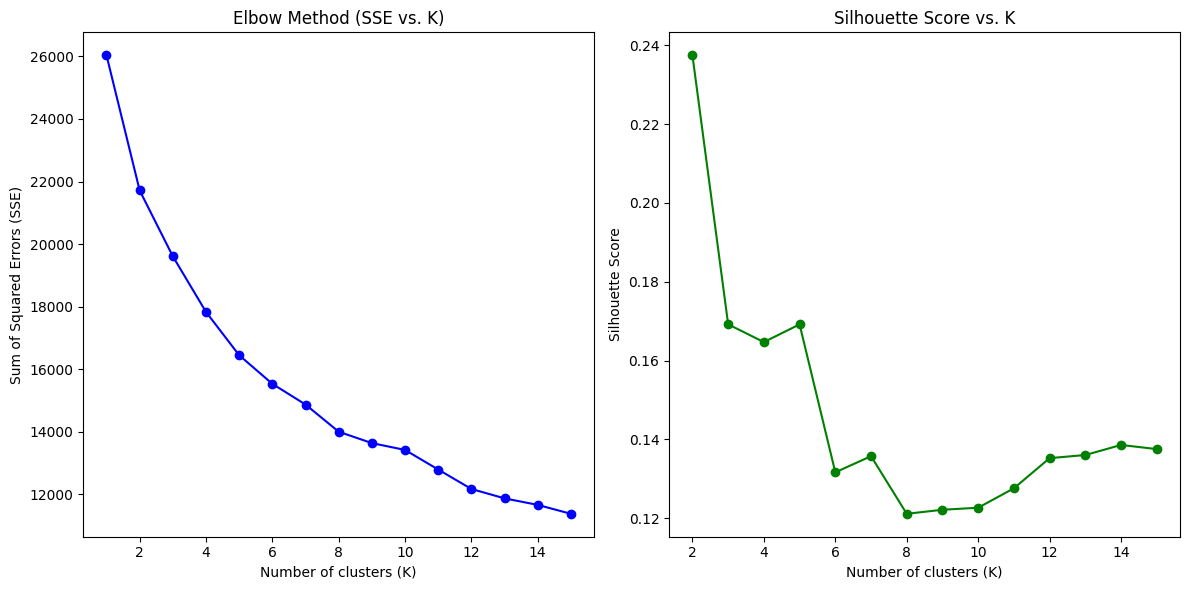

In [108]:
# Elbow Method
sse = []
sil_scores = []

# Try different values for K (clusters) from 1 to 15
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center
    if k > 1:  # Silhouette score is undefined for k=1, so start from k=2
        sil_score = silhouette_score(features_scaled, kmeans.labels_)
        sil_scores.append(sil_score)

# Plot Elbow Method
plt.figure(figsize=(12, 6))

# Plot SSE (Elbow Method)
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), sse, marker='o', color='blue')
plt.title('Elbow Method (SSE vs. K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')

# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 16), sil_scores, marker='o', color='green')
plt.title('Silhouette Score vs. K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Step 4: Pick the Best K
# You can use the Elbow Method and/or Silhouette Score to pick the optimal K.
# Based on the plots, you can decide the best K.

# For example, if the Elbow Method suggests K=5 and Silhouette Score suggests K=5 as well, we choose K=5.
best_k = 5  # Choose based on the elbow plot and silhouette score plot
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_combined['cluster'] = kmeans.fit_predict(features_scaled)


### Agglomerative clustering

In [110]:
# Apply Agglomerative Clustering
try:
    # Create Agglomerative Clustering model
    agglomerative = AgglomerativeClustering(n_clusters=8, linkage='ward')  # Adjust 'n_clusters' as needed
    df_combined['cluster'] = agglomerative.fit_predict(features_scaled)
    print("Agglomerative clustering completed successfully.")
except Exception as e:
    print(f"Error during Agglomerative clustering: {e}")


Agglomerative clustering completed successfully.


In [111]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Step 1: Extract Cluster Labels
cluster_labels = df_combined['cluster']

# Step 2: Check for Valid Clusters
if len(set(cluster_labels)) <= 1:  # Ensure we have at least 2 clusters for meaningful evaluation
    print("Agglomerative Clustering did not form enough clusters for evaluation.")
else:
    # Step 3: Silhouette Score
    silhouette_avg = silhouette_score(features_scaled, cluster_labels)
    print(f"Silhouette Score: {silhouette_avg:.2f}")
    
    # Step 4: Davies-Bouldin Index (lower is better)
    davies_bouldin = davies_bouldin_score(features_scaled, cluster_labels)
    print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")


Silhouette Score: 0.12
Davies-Bouldin Index: 1.81


### DBSCAN

In [113]:
# Apply DBSCAN Clustering

try:
    # Parameters: eps (maximum distance between points) and min_samples (minimum points to form a cluster)
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust these parameters as needed
    df_combined['cluster'] = dbscan.fit_predict(features_scaled)
    print("DBSCAN clustering completed successfully.")
except Exception as e:
    print(f"Error during DBSCAN clustering: {e}")


DBSCAN clustering completed successfully.


In [114]:
# Step 1: Extract Cluster Labels
cluster_labels = df_combined['cluster']

# Step 2: Check for Valid Clusters
# DBSCAN might assign -1 to noise points, so we need to ensure we have valid clusters
if len(set(cluster_labels)) <= 1:  # DBSCAN needs at least 2 clusters for meaningful evaluation
    print("DBSCAN did not form enough clusters for evaluation.")
else:
    # Step 3: Silhouette Score (ignores noise points, requires more than 1 cluster)
    silhouette_avg = silhouette_score(features_scaled[cluster_labels != -1], cluster_labels[cluster_labels != -1])
    print(f"Silhouette Score: {silhouette_avg:.2f}")
    
    # Step 4: Davies-Bouldin Index (lower is better, evaluates all points including noise)
    davies_bouldin = davies_bouldin_score(features_scaled, cluster_labels)
    print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")


Silhouette Score: 0.98
Davies-Bouldin Index: 1.46


## **Final recommendation**

In [145]:
def prepare_user_features(audio_features, scaler, feature_columns):
    """
    Scale and prepare user audio features for clustering.
    Handles missing features by filling with zeros.
    """
    import pandas as pd
    
    # Convert audio features to a DataFrame
    features_df = pd.DataFrame([audio_features])  
    
    # Ensure all required feature columns exist in the data
    for column in feature_columns:
        if column not in features_df.columns:
            features_df[column] = 0  # Fill missing columns with default values
    
    # Select only the feature columns
    selected_features = features_df[feature_columns]
    
    # Scale the features
    scaled_features = scaler.transform(selected_features)
    return scaled_features

def full_workflow(user_input):
    search_results = sp.search(q=user_input, type='track,artist', limit=1)
    
    if not search_results['tracks']['items'] and not search_results['artists']['items']:
        print(f"No results found for '{user_input}'.")
        return
    
    if search_results['tracks']['items']:
        # If input matches a song, fetch audio features
        track = search_results['tracks']['items'][0]
        print(f"Found song: {track['name']} by {track['artists'][0]['name']}")
        
        # Check if the song is present in the ww_de DataFrame
        if track['name'] in ww_de['song_title'].values:
            print(f"The song '{track['name']}' is found in your ww_de DataFrame.")
            # Recommend one random song from ww_de
            random_recommendation = ww_de.sample(n=1)
            print("Recommended Song from ww_de:")
            print(random_recommendation[['song_title', 'artist']])
            for song in random_recommendation['song_title']:
                play_song(song)
        else:
            user_audio_features = get_audio_features(track['id'])
            
            if user_audio_features:
                try:
                    user_features_scaled = prepare_user_features(user_audio_features, scaler, feature_columns)
                    user_cluster = kmeans.predict(user_features_scaled)[0]
                    print(f"Song '{track['name']}' belongs to cluster {user_cluster}.")
                    
                    recommendations = recommend_from_cluster(df_combined, user_cluster)
                    if recommendations is not None:
                        recommended_song = recommendations[['song_title', 'artist']].iloc[0]
                        print("Recommended Song based on musical similarity:")
                        print(recommended_song)
                        play_song(recommended_song['song_title'])
                    else:
                        print("No recommendations found.")
                except Exception as e:
                    print(f"Error during recommendation process: {e}")
            else:
                print(f"Unable to retrieve audio features for '{track['name']}'.")
    
    elif search_results['artists']['items']:
        artist = search_results['artists']['items'][0]
        print(f"Found artist: {artist['name']}")
        artist_tracks = sp.artist_top_tracks(artist['id'])['tracks']

        if artist_tracks:
            print(f"Top song by {artist['name']}:")
            top_song = artist_tracks[0]
            print(f"- {top_song['name']} (Listen: https://open.spotify.com/track/{top_song['id']})")
        else:
            print(f"No top tracks found for artist '{artist['name']}'.")


# Dynamic User Input
user_input = input("Enter a song or artist name: ")
full_workflow(user_input)


Enter a song or artist name:  jackson


HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5LxvwujISqiB8vpRYv887S with Params: {} returned 403 due to None


Found song: I Want You Back by The Jackson 5
Error fetching audio features: http status: 403, code:-1 - https://api.spotify.com/v1/audio-features/?ids=5LxvwujISqiB8vpRYv887S:
 None, reason: None
Unable to retrieve audio features for 'I Want You Back'.


## **Streamlit**

In [ ]:
# For my reference:

# 1. Open Visual Code Studio
# 2. Right click on 'app.py'
# 3. Open in Integrated Terminal
# 4. Run 'streamlit run app.py'
# 5. A new browser tab opens : http://localhost:8502/